In [ ]:
import osmnx as ox
import networkx as nx
import folium
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


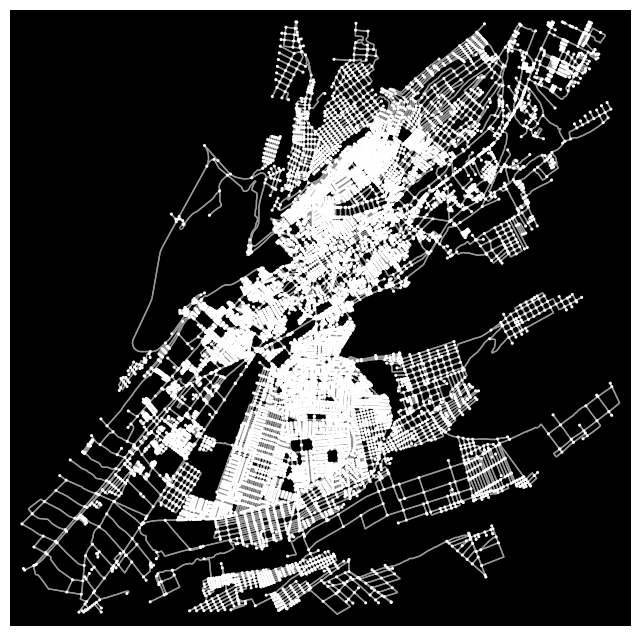

In [ ]:
# Cargar la red vial (modo: auto, caminando, bicicleta)
center_point = [-18.027808, -70.251069]
G = ox.graph_from_point(center_point, dist=10000, network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [8]:
puntos = [
    (-18.025947, -70.251223), # Punto inicial (Puerta de la U Av. Cusco)
    (-18.018047, -70.253128), # Plaza Vea
    (-18.013997, -70.248859), # DM Hotel
    (-18.013682, -70.250590), # Arco parabolico
    (-18.016574, -70.252357), # Ferrocarril
    (-18.013078, -70.254401), # Museo Ferrobiario
]

In [ ]:
mapa = folium.Map(location=puntos[0], titles="Puntos de Entrega", zoom_start=14)
    
for i, idx in enumerate(puntos):
    folium.Marker(location=[idx[0],idx[1]], tooltip=f"Punto {i}").add_to(mapa)

mapa

In [9]:
nodos = [ox.distance.nearest_nodes(G, lon, lat) for lat, lon in puntos]

In [10]:
def crear_matriz_distancias(grafo, nodos):
    n = len(nodos)
    distancias = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist = nx.shortest_path_length(grafo, nodos[i], nodos[j], weight='length')
                distancias[i][j] = dist
    return distancias


In [ ]:
def resolver_tsp(matriz):
    n = len(matriz)
    manager = pywrapcp.RoutingIndexManager(n, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        return int(matriz[manager.IndexToNode(from_index)][manager.IndexToNode(to_index)])
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)
    
    ruta = []
    if solution:
        index = routing.Start(0)
        while not routing.IsEnd(index):
            ruta.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        ruta.append(manager.IndexToNode(index))
    return ruta


In [12]:
def visualizar_ruta(grafo, puntos, nodos, orden):
    mapa = folium.Map(location=puntos[0], zoom_start=14)
    
    for i, idx in enumerate(orden):
        folium.Marker(puntos[idx], tooltip=f"Punto {i}").add_to(mapa)
    
    for i in range(len(orden) - 1):
        path = nx.shortest_path(grafo, nodos[orden[i]], nodos[orden[i+1]], weight="length")
        coords = [(grafo.nodes[n]['y'], grafo.nodes[n]['x']) for n in path]
        folium.PolyLine(coords, color="blue", weight=4).add_to(mapa)

    return mapa


In [13]:
matriz = crear_matriz_distancias(G, nodos)
orden = resolver_tsp(matriz)
mapa = visualizar_ruta(G, puntos, nodos, orden)
mapa
